## Training the CNN model on my own Dog_breeds Dataset

In [ ]:
!pip install torch torchvision matplotlib scikit-learn


In [ ]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = "/content/drive/MyDrive/dog_dataset/dog_dataset"

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [11]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

class_names = dataset.classes
num_classes = len(class_names)

print("Classes:", len(class_names))
print("Total images:", len(dataset))


Classes: 20
Total images: 400


In [12]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [13]:
model = models.resnet18(pretrained=True)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 93.6MB/s]


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [15]:
EPOCHS = 10

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # ---- Training ----
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- Validation ----
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {accuracy:.2f}%")



Epoch 1/10
Train Loss: 2.4940
Val Loss: 1.7534
Val Accuracy: 66.25%

Epoch 2/10
Train Loss: 1.2698
Val Loss: 0.9546
Val Accuracy: 88.75%

Epoch 3/10
Train Loss: 0.7552
Val Loss: 0.6039
Val Accuracy: 93.75%

Epoch 4/10
Train Loss: 0.4882
Val Loss: 0.4475
Val Accuracy: 95.00%

Epoch 5/10
Train Loss: 0.3612
Val Loss: 0.3706
Val Accuracy: 93.75%

Epoch 6/10
Train Loss: 0.2758
Val Loss: 0.2976
Val Accuracy: 95.00%

Epoch 7/10
Train Loss: 0.2328
Val Loss: 0.2991
Val Accuracy: 95.00%

Epoch 8/10
Train Loss: 0.2062
Val Loss: 0.2403
Val Accuracy: 95.00%

Epoch 9/10
Train Loss: 0.1710
Val Loss: 0.2363
Val Accuracy: 95.00%

Epoch 10/10
Train Loss: 0.1405
Val Loss: 0.2291
Val Accuracy: 95.00%


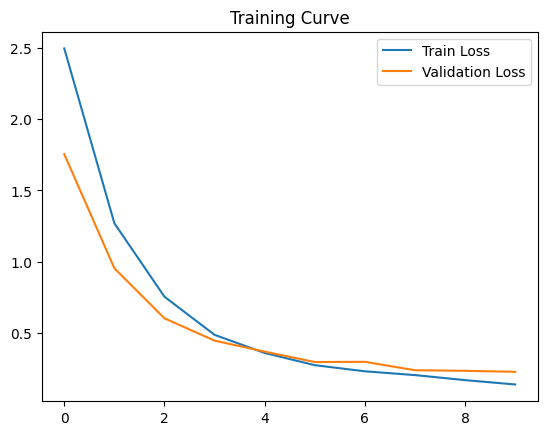

In [16]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Training Curve")
plt.show()
